In [99]:
import warnings
warnings.filterwarnings("ignore")

In [100]:
import pandas as pd
import numpy as np
import chromadb
from pprint import pprint

import matplotlib.pyplot as plt
import os, sys, json
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

import utils.llm_model as utils
from langchain.embeddings.openai import OpenAIEmbeddings

In [101]:
#../data_files/week_clean_without_comment_labeled/data_python.csv
data = pd.read_csv("../data_files/reduced/reduced_week7.csv")
data = pd.DataFrame(data)
data.columns

Index(['Unnamed: 0', 'user_id', 'code_content', 'Email', 'label'], dtype='object')

In [102]:
data.head()

,Unnamed: 0,user_id,code_content,Email,label
0,0,619,import json\nimport re\n \nclass Util():\n de...,abrhamaddis32@gmail.com,Intermediate
1,1,761,! pip install transformers bitsandbytes peft t...,lillian.alehegn@aait.edu.et,Basic
2,2,652,! pip install transformers bitsandbytes peft t...,fanuelabebe@gmail.com,Advanced
3,3,746,"%import sys, os, json, re, zipfile, csv\nimpor...",ekram.kedir.asfaw@gmail.com,Intermediate
4,4,705,import json\nimport re\n \nclass Util:\n def ...,redogirma@gmail.com,Intermediate


In [103]:
samples = data['code_content'].tolist()
# text-embedding-3-small text-embedding-ada-002

# Initialize the OpenAIEmbeddings model
embed_model = OpenAIEmbeddings(model="text-embedding-3-small")

# Embed the documents
embedded_documents = embed_model.embed_documents(samples)

In [104]:
chroma_client = chromadb.Client()

In [105]:
# chroma_client.delete_collection(name="test1")

In [106]:

chroma_collection = chroma_client.create_collection("test1", embedding_function=embedded_documents)
ids = [str(i) for i in range(len(samples))]
chroma_collection.add(ids=ids, embeddings=embedded_documents)

In [107]:
collection = chroma_client.get_collection(name="test1")
collection

Collection(name=test1)

In [108]:
# chroma_client.delete_collection(name="test1")

In [109]:
fetched_vector = collection.get(include=['embeddings', 'documents', 'metadatas'])

In [110]:
optimal_k = utils.silhouette_to_find_optimal_k(fetched_vector['embeddings'])

In [125]:
optimal_k

5

In [112]:
cluster_labels, level_embeddings = utils.kmeans_clustering(optimal_k, fetched_vector['embeddings'])

In [113]:
len(cluster_labels)

11

In [114]:
data['cluster_labels'] = cluster_labels

In [115]:
#pprint(data['code_content'][0])

In [116]:
data.head()

,Unnamed: 0,user_id,code_content,Email,label,cluster_labels
0,0,619,import json\nimport re\n \nclass Util():\n de...,abrhamaddis32@gmail.com,Intermediate,2
1,1,761,! pip install transformers bitsandbytes peft t...,lillian.alehegn@aait.edu.et,Basic,3
2,2,652,! pip install transformers bitsandbytes peft t...,fanuelabebe@gmail.com,Advanced,3
3,3,746,"%import sys, os, json, re, zipfile, csv\nimpor...",ekram.kedir.asfaw@gmail.com,Intermediate,1
4,4,705,import json\nimport re\n \nclass Util:\n def ...,redogirma@gmail.com,Intermediate,0


In [117]:
data = data.drop('Unnamed: 0', axis=1)

In [118]:
data.to_csv('../data_files/clustered_data/week7_reduced_clustered.csv', index=True)

In [120]:
# data['code_content'][13] umap 

In [121]:
import numpy as np
from sklearn.decomposition import PCA
def calculate_matched_percentages(level_df, cluster_labels, decimal_places=2):
    percentages = {}
    total_samples = len(cluster_labels)
    
    for label in np.unique(cluster_labels):
        matched_labels = level_df.loc[cluster_labels == label, 'label']
        unique, counts = np.unique(matched_labels, return_counts=True)
        
        percentages[label] = {}
        
        for txt, count in zip(unique, counts):
            percentage = count / total_samples * 100
            rounded_percentage = round(percentage, decimal_places)
            percentages[label][txt] = rounded_percentage
    
    return percentages
percentage = calculate_matched_percentages(data, cluster_labels)
percentage

{0: {'Advanced': 9.09, 'Basic': 9.09, 'Intermediate': 18.18},
 1: {'Intermediate': 18.18},
 2: {'Intermediate': 9.09},
 3: {'Advanced': 9.09, 'Basic': 9.09, 'Intermediate': 9.09},
 4: {'Intermediate': 9.09}}

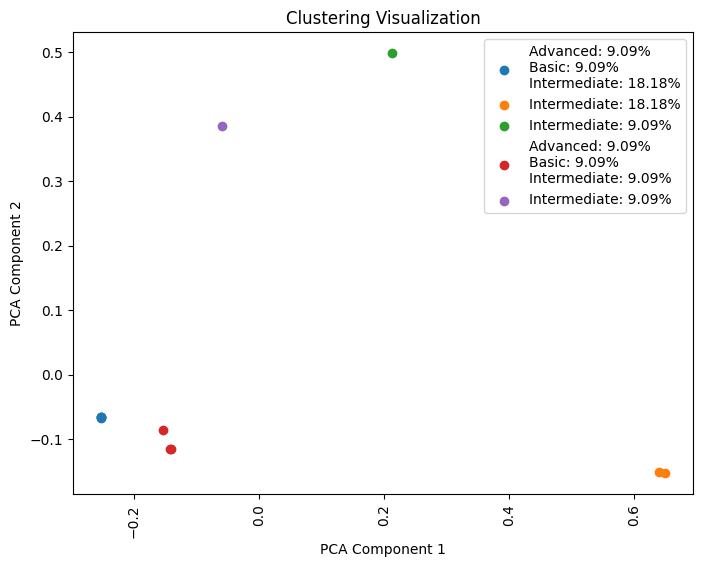

In [122]:
def visualize_clusters(level_embeddings, cluster_labels, level_df):
    pca = PCA(n_components=2, random_state=42)
    embeddings_2d = pca.fit_transform(level_embeddings)

    percentages = calculate_matched_percentages(level_df, cluster_labels)

    plt.figure(figsize=(8, 6))
    for label in np.unique(cluster_labels):
        if label in percentages:
            label_text = '\n'.join([f'{key}: {value}%' for key, value in percentages[label].items()])
            plt.scatter(embeddings_2d[cluster_labels == label, 0], embeddings_2d[cluster_labels == label, 1],
                            label=label_text)
        else:
            label_text = f'Cluster {label}'
            plt.scatter(embeddings_2d[cluster_labels == label, 0], embeddings_2d[cluster_labels == label, 1],
                            label=label_text)

    plt.title('Clustering Visualization')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()

    # Rotate the x-axis labels vertically
    plt.xticks(rotation='vertical')
    
    plt.show()

visualize_clusters(level_embeddings, cluster_labels, data)

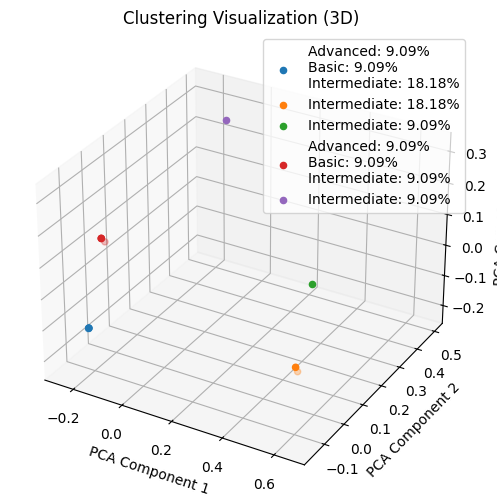

In [123]:
def visualize_clusters_3d(job_embeddings, cluster_labels, level_df):
    pca = PCA(n_components=3, random_state=42)
    embeddings_3d = pca.fit_transform(job_embeddings)

    percentages = calculate_matched_percentages(level_df, cluster_labels)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    for label in np.unique(cluster_labels):      
        if label in percentages:
            label_text = '\n'.join([f'{key}: {value}%' for key, value in percentages[label].items()])
            ax.scatter(embeddings_3d[cluster_labels == label, 0], embeddings_3d[cluster_labels == label, 1], embeddings_3d[cluster_labels == label, 2],
                    label=label_text)
        else:
            label_text = f'Cluster {label}'
            ax.scatter(embeddings_3d[cluster_labels == label, 0], embeddings_3d[cluster_labels == label, 1], embeddings_3d[cluster_labels == label, 2],
                    label=label_text)
    ax.set_title('Clustering Visualization (3D)')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    ax.legend()

    plt.show()

visualize_clusters_3d(level_embeddings, cluster_labels, data)

In [124]:
def Fetch_Each_clustering_Content(texts, cluster_labels):
    # Write text data for each cluster to separate text files
    for cluster_label in range(optimal_k):
        cluster_texts = np.array(texts)[np.array(cluster_labels) == cluster_label]
        save_path = f'../txt/w7/cluster_{cluster_label}_texts.txt'

        with open(save_path, 'w') as file:
            for text in cluster_texts:
                file.write(text + '\n')
    
    return cluster_labels

# Specify the optimal number of clusters and the path for saving the text file
texts = data['code_content'].tolist()
# Perform k-means clustering and save the cluster labels
Fetch_Each_clustering_Content(texts, cluster_labels)

array([2, 3, 3, 1, 0, 0, 0, 4, 3, 0, 1], dtype=int32)